In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pylab

import seaborn as sns

import csv

import scipy
from scipy import stats
import statistics

In [2]:
%matplotlib inline
import deepdish as dd
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as patches
import numpy as np
import brainiak.eventseg.event
from scipy import stats
from scipy.stats import norm, zscore, pearsonr
from scipy.signal import gaussian, convolve
from sklearn import decomposition
import seaborn as sns 

In [3]:
#import cupy as cp
from easyesn.optimizers import GradientOptimizer
from easyesn import PredictionESN
from easyesn.optimizers import GridSearchOptimizer
from easyesn import helper as hlp
import numpy as np
#from wikipedia2vec import Wikipedia2Vec

#import nltk
#nltk.download('stopwords')
#from nltk.corpus import stopwords


vectorDim = 100

numNode = 1000

reps = 50
kvalues = 20

# the data structures to save the means for the coherent and incoherent
coherent_means = np.empty(reps)
incoherent_means = np.empty(reps)

coherent_vars_1 = np.empty(reps)
coherent_vars_2 = np.empty(reps) 

incoherent_vars_1 = np.empty(reps)
incoherent_vars_2 = np.empty(reps) 

likelihood = np.zeros([kvalues,reps,2])



#here is a small bit of data to train the reservoir.  We dont care
# if it learns because we are analysing the reseroir units, and
#not the readouts

in_small = np.load('in_small.npy')
out_small = np.load('out_small.npy')

Using Numpy backend.


In [4]:
#reservoirStatesBuffer[:,:resn]


print(len(in_small))
print(len(out_small))

10000
10000


In [5]:
#here we import the word vectors for the intact and shifted 
# not the fall texts.  Avoids using the big wikipedia2vec pkl file

inputDataTestingIntact = np.load('inputDataTestingIntact.npy')
inputDataTestingShift = np.load('inputDataTestingShift.npy')


In [6]:
# now the radical loop: 1. run 2 reservoirs; 2. calculate time contst; 3.sort;  4. segment (ubuntu)

for res_seed in range(reps):
 
    ###################################################################
    #
    #               1.1 run reservoir on intact text


    # set the seed
    np.random.seed(res_seed)

    # set up the reservoir
    # leakingRate=0.2 changing too fast, mutliple with 0.05; changed
    esn = PredictionESN(n_input=vectorDim, n_output=vectorDim, n_reservoir=numNode, leakingRate=0.05, regressionParameters=[1e-2], solver="lsqr", feedback=False)

    # train the reervoir with a new seed
    esn.fit(in_small, out_small, transientTime="Auto", verbose=1)

    #run the reservoir
    reservoirStatesBuffer = np.empty((0,numNode))
    prediction,reservoirStatesBuffer  = esn.predict(inputDataTestingIntact)
    reservoirStatesBuffer = reservoirStatesBuffer.T
    print(reservoirStatesBuffer.shape)
    reservoirStatesBuffer = reservoirStatesBuffer[:,101:]
    print(reservoirStatesBuffer.shape)
    print(prediction.shape)

    reservoirStatesBuffer1 = reservoirStatesBuffer

    ###################################################################
    #
    #               1.2 run reservoir on shifted text

    # set the seed
    np.random.seed(res_seed)

    # set up the reservoir
    # leakingRate=0.2 changing too fast, mutliple with 0.05; changed
    esn = PredictionESN(n_input=vectorDim, n_output=vectorDim, n_reservoir=numNode, 
                        leakingRate=0.05, regressionParameters=[1e-2], solver="lsqr", feedback=False)

    # train the reervoir with a new seed
    esn.fit(in_small, out_small, transientTime="Auto", verbose=1)

    #run the reservoir
    reservoirStatesBuffer = np.empty((0,numNode))
    prediction,reservoirStatesBuffer  = esn.predict(inputDataTestingShift)
    reservoirStatesBuffer = reservoirStatesBuffer.T
    print(reservoirStatesBuffer.shape)
    reservoirStatesBuffer = reservoirStatesBuffer[:,101:]
    print(reservoirStatesBuffer.shape)
    print(prediction.shape)

    reservoirStatesBuffer2 = reservoirStatesBuffer

    


    ###################################################################
    #
    #               2. calculate time contst

    # get the subset of data that has the different-to-same shift

    resn = numNode
    index = 0
    begin=433
    end=683
    data = reservoirStatesBuffer1[begin:end,index:index+resn] - reservoirStatesBuffer2[begin:end,index:index+resn]
    print(data.shape)
    dataT=data.T

    timeconstants = np.zeros(dataT.shape[0])
    res_maxes = np.zeros(dataT.shape[0])

    #calculate the alignment time:  dataT(neurons,time)
    #interate over reservoir neuron
    for neuron in range(dataT.shape[0]):
        # get the value
        max = abs(dataT[neuron,0])
        if max > -1:  #WAS 0.05
            for timestep in range(dataT.shape[1]):
                if abs(dataT[neuron,timestep]) < max/2:
                    timeconstants[neuron] = timestep
                    res_maxes[neuron] = max
                    max=-1     
                    
    ###################################################################
    #
    #               3.  sort
    
    save_timeconstants = timeconstants
    timeconstants = np.sort(save_timeconstants)
    # these sorted time constants can be used to display the nice distribution
    
    #get the indices - that is (timesteps, neuron)
    timesteps = reservoirStatesBuffer1.shape[0]
    neurons = reservoirStatesBuffer1.shape[1]
    
    # add a column to store the time constants into the 

    reservoirStates1SortedT = np.zeros((neurons,timesteps+1))
    reservoirStates1SortedT[:,:-1] = reservoirStatesBuffer1.T

    #create a new column for the time constants
    reservoirStates1SortedT[:,682]=save_timeconstants
    
    #do the sort, then remove the column of time constants
    SortedStates = reservoirStates1SortedT[np.argsort(reservoirStates1SortedT[:, 682])]
    temp=SortedStates[:,0:682]
    NTF_SortedStates = temp.T
    
    
    ###################################################################
    #
    #               4. Segment
    

    # get the pieces
    #NTF_time1=NTF_SortedStates[:,0:99]
    #NTF_time2=NTF_SortedStates[:,900:999]
    
    NTF_time1=NTF_SortedStates[:,100:199]
    NTF_time2=NTF_SortedStates[:,800:899]
 
    if res_seed == 0:
        NTF_time1_cumul = NTF_time1
        NTF_time2_cumul = NTF_time2
    else:
        NTF_time1_cumul = NTF_time1 + NTF_time1_cumul
        NTF_time2_cumul = NTF_time2 + NTF_time2_cumul
    
    # now test the different k values
    
    for iteration in range(kvalues):

        ###################################################################
        #
        #               4. Segment

        #simple data structure for testing

        step = 2
        # Train the two HMS with the predicted segments
        ev_time1 = brainiak.eventseg.event.EventSegment((iteration+1)*step)
        ev_time1.fit(NTF_time1)

        ev_time2 = brainiak.eventseg.event.EventSegment((iteration+1)*step)
        ev_time2.fit(NTF_time2)
        print((iteration+1)*step)

        # save the variablility scores

        coherent_ev1_var = ev_time1.event_var_
        coherent_ev2_var = ev_time2.event_var_

        # save likelihood scores
        likelihood[iteration, res_seed,0] = ev_time1.ll_[len(ev_time1.ll_)-1]
        likelihood[iteration, res_seed,1] = ev_time2.ll_[len(ev_time2.ll_)-1]


        print("res_seed = ", res_seed)
        print("Likelihood")
        print(*likelihood[iteration, res_seed,:], sep='\n')


100% (9603 of 9603) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)


100% (9603 of 9603) |####################| Elapsed Time: 0:00:08 Time:  0:00:08


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  0
Likelihood
-1082.936511375022
-1073.8682771154417
4
res_seed =  0
Likelihood
-984.1308509124317
-984.8460497568014
6
res_seed =  0
Likelihood
-908.7407176304171
-899.704456626267
8
res_seed =  0
Likelihood
-856.6179166775499
-841.0358711805026
10
res_seed =  0
Likelihood
-808.8811512721314
-796.8548055582826
12
res_seed =  0
Likelihood
-764.9105260201037
-755.3457281176474
14
res_seed =  0
Likelihood
-725.8852220312122
-729.3810585379641
16
res_seed =  0
Likelihood
-693.9931185670212
-688.9979101203567
18
res_seed =  0
Likelihood
-665.4063410647706
-666.4299057725482
20
res_seed =  0
Likelihood
-635.0305701084206
-635.5967926732502
22
res_seed =  0
Likelihood
-611.978880971111
-609.226902355797
24
res_seed =  0
Likelihood
-587.0112590549174
-587.1174385986874
26
res_seed =  0
Likelihood
-569.4749023707284
-572.222992825784
28
res_seed =  0
Likelihood
-550.8107495066153
-547.0832722753468
30
res_seed =  0
Likelihood
-529.566

100% (9615 of 9615) |####################| Elapsed Time: 0:00:08 Time:  0:00:08


(682, 1101)
(682, 1000)
(682, 100)


100% (9615 of 9615) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  1
Likelihood
-1085.6798383725868
-1072.6727246617
4
res_seed =  1
Likelihood
-990.2566370737734
-984.489645349175
6
res_seed =  1
Likelihood
-902.0555180417422
-904.9563386108847
8
res_seed =  1
Likelihood
-852.1655368954889
-835.0057636537172
10
res_seed =  1
Likelihood
-814.0856290467952
-792.8747166651779
12
res_seed =  1
Likelihood
-767.0910208351738
-740.4236668122597
14
res_seed =  1
Likelihood
-732.8220431510649
-706.1387622310501
16
res_seed =  1
Likelihood
-695.7516177620964
-669.9274769872005
18
res_seed =  1
Likelihood
-665.1736893096801
-642.9951687852468
20
res_seed =  1
Likelihood
-638.3491158277803
-621.1159614279796
22
res_seed =  1
Likelihood
-610.0939185864337
-595.0882636655904
24
res_seed =  1
Likelihood
-596.510128386369
-568.3769163641069
26
res_seed =  1
Likelihood
-574.9674242777293
-559.1936855111237
28
res_seed =  1
Likelihood
-558.5729222764841
-533.1667062313267
30
res_seed =  1
Likelihood
-530.953

100% (9606 of 9606) |####################| Elapsed Time: 0:00:08 Time:  0:00:08


(682, 1101)
(682, 1000)
(682, 100)


100% (9606 of 9606) |####################| Elapsed Time: 0:00:08 Time:  0:00:08


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  2
Likelihood
-1078.7954176658918
-1066.483471967602
4
res_seed =  2
Likelihood
-991.3179023054107
-977.7346086069043
6
res_seed =  2
Likelihood
-923.5889015490411
-890.9557027903003
8
res_seed =  2
Likelihood
-881.7817981735365
-836.2763772130103
10
res_seed =  2
Likelihood
-829.6486476247885
-786.1357904006046
12
res_seed =  2
Likelihood
-793.947386319811
-745.9982150727823
14
res_seed =  2
Likelihood
-763.1974918172566
-703.6353484334584
16
res_seed =  2
Likelihood
-728.7338985952017
-668.2470826274048
18
res_seed =  2
Likelihood
-695.3683217317028
-650.2049432239426
20
res_seed =  2
Likelihood
-665.0441809589184
-623.3799978529698
22
res_seed =  2
Likelihood
-639.7091189719457
-611.4527678568752
24
res_seed =  2
Likelihood
-606.333270907739
-581.6600356826297
26
res_seed =  2
Likelihood
-591.2716070120044
-561.4858264596252
28
res_seed =  2
Likelihood
-573.6902846002441
-536.0028831103123
30
res_seed =  2
Likelihood
-556.6

100% (9615 of 9615) |####################| Elapsed Time: 0:00:10 Time:  0:00:10


(682, 1101)
(682, 1000)
(682, 100)


100% (9615 of 9615) |####################| Elapsed Time: 0:00:14 Time:  0:00:14


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  3
Likelihood
-1074.2625389417865
-1069.4935125534078
4
res_seed =  3
Likelihood
-991.5217466081907
-973.8302917810406
6
res_seed =  3
Likelihood
-923.5582442331179
-900.0554750317644
8
res_seed =  3
Likelihood
-870.4068941342074
-838.1544526647517
10
res_seed =  3
Likelihood
-821.0380808001042
-782.7984509134516
12
res_seed =  3
Likelihood
-770.5193454862213
-741.4249819824589
14
res_seed =  3
Likelihood
-737.8126961478902
-705.0697140215597
16
res_seed =  3
Likelihood
-706.0518731017261
-670.1565517684044
18
res_seed =  3
Likelihood
-678.8298693344052
-645.2561206699426
20
res_seed =  3
Likelihood
-643.699820841251
-624.28889345702
22
res_seed =  3
Likelihood
-613.0934726486727
-609.0363573207271
24
res_seed =  3
Likelihood
-594.2525913540062
-580.4001411806026
26
res_seed =  3
Likelihood
-576.8861720310067
-557.135609893359
28
res_seed =  3
Likelihood
-556.9164553325405
-540.487638050662
30
res_seed =  3
Likelihood
-532.014

100% (9611 of 9611) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)


100% (9611 of 9611) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  4
Likelihood
-1091.4014410015182
-1077.190827783274
4
res_seed =  4
Likelihood
-996.8752444353371
-982.0310314521703
6
res_seed =  4
Likelihood
-922.9587022740816
-912.5261612181695
8
res_seed =  4
Likelihood
-874.0103150495491
-851.3434140613757
10
res_seed =  4
Likelihood
-820.5047757832958
-801.8359196339989
12
res_seed =  4
Likelihood
-787.5010674900519
-760.4664320518245
14
res_seed =  4
Likelihood
-744.7190464902283
-721.4008203633223
16
res_seed =  4
Likelihood
-708.5747583103682
-687.7706125885725
18
res_seed =  4
Likelihood
-687.3132689557865
-664.018757415594
20
res_seed =  4
Likelihood
-656.9639417506507
-635.3408291503384
22
res_seed =  4
Likelihood
-635.657359684802
-618.237569811202
24
res_seed =  4
Likelihood
-606.5933140870388
-590.5806226971906
26
res_seed =  4
Likelihood
-589.9018556543582
-576.0728997073809
28
res_seed =  4
Likelihood
-570.6338492964022
-555.948587192996
30
res_seed =  4
Likelihood
-554.286

100% (9619 of 9619) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)


100% (9619 of 9619) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  5
Likelihood
-1071.313025136733
-1076.9066704221725
4
res_seed =  5
Likelihood
-978.4580839881374
-985.6914697316502
6
res_seed =  5
Likelihood
-902.4745695715343
-903.263171639855
8
res_seed =  5
Likelihood
-845.5346015678465
-850.4524890901656
10
res_seed =  5
Likelihood
-789.4108601662964
-806.0017079549449
12
res_seed =  5
Likelihood
-753.8546676216342
-769.1033912514389
14
res_seed =  5
Likelihood
-717.8515815030643
-734.6996115814229
16
res_seed =  5
Likelihood
-686.4151049942743
-703.4217049641873
18
res_seed =  5
Likelihood
-661.2482197813081
-679.0802967644321
20
res_seed =  5
Likelihood
-631.3052675874861
-649.5022651255559
22
res_seed =  5
Likelihood
-607.3497749135707
-629.7969444110541
24
res_seed =  5
Likelihood
-585.6900236682482
-601.3513521532975
26
res_seed =  5
Likelihood
-564.024894665642
-588.1612500298442
28
res_seed =  5
Likelihood
-549.3067780454874
-568.3567508917519
30
res_seed =  5
Likelihood
-530.4

100% (9611 of 9611) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)


100% (9611 of 9611) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  6
Likelihood
-1081.0380348437081
-1066.5510296645698
4
res_seed =  6
Likelihood
-997.0793740007048
-971.5649392155178
6
res_seed =  6
Likelihood
-921.6891555763308
-893.479727003269
8
res_seed =  6
Likelihood
-870.2613119303271
-835.2281505794808
10
res_seed =  6
Likelihood
-820.3117093205575
-796.8950769402442
12
res_seed =  6
Likelihood
-783.2275120117582
-752.0233774556282
14
res_seed =  6
Likelihood
-749.2438253101767
-714.2685605776221
16
res_seed =  6
Likelihood
-726.2181320033884
-680.1269468229211
18
res_seed =  6
Likelihood
-690.7262896612536
-654.1207884443952
20
res_seed =  6
Likelihood
-666.5043900346727
-624.0678079701725
22
res_seed =  6
Likelihood
-648.9157967236926
-595.3660603332045
24
res_seed =  6
Likelihood
-619.0594366676818
-567.6339173008141
26
res_seed =  6
Likelihood
-602.6073643126279
-555.0673463707637
28
res_seed =  6
Likelihood
-584.7044309716347
-534.567882941069
30
res_seed =  6
Likelihood
-570.

100% (9608 of 9608) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)


100% (9608 of 9608) |####################| Elapsed Time: 0:00:08 Time:  0:00:08


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  7
Likelihood
-1069.7001966221524
-1073.0986503099866
4
res_seed =  7
Likelihood
-979.6011108522415
-979.028750471043
6
res_seed =  7
Likelihood
-897.7205997436541
-902.3457010679243
8
res_seed =  7
Likelihood
-845.7755879424169
-849.89305670511
10
res_seed =  7
Likelihood
-810.2353933770788
-804.3123998384244
12
res_seed =  7
Likelihood
-763.9831908157852
-757.3207513527789
14
res_seed =  7
Likelihood
-721.8279099266118
-726.2071272588704
16
res_seed =  7
Likelihood
-687.8989995165244
-690.539317606706
18
res_seed =  7
Likelihood
-652.0880942281352
-659.6311221799119
20
res_seed =  7
Likelihood
-628.0805499734126
-626.3773237252273
22
res_seed =  7
Likelihood
-603.427670475408
-600.8500426126766
24
res_seed =  7
Likelihood
-581.3683053511489
-585.8590805247243
26
res_seed =  7
Likelihood
-561.4698469148404
-564.8672442604715
28
res_seed =  7
Likelihood
-548.0647932023466
-545.2743955094297
30
res_seed =  7
Likelihood
-528.487

100% (9600 of 9600) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)


100% (9600 of 9600) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  8
Likelihood
-1082.6975371262677
-1074.8399053972173
4
res_seed =  8
Likelihood
-996.570016009976
-968.609840946654
6
res_seed =  8
Likelihood
-920.628364256698
-892.881142985317
8
res_seed =  8
Likelihood
-866.5473031355166
-833.4761614751335
10
res_seed =  8
Likelihood
-821.28924995971
-791.5638228356587
12
res_seed =  8
Likelihood
-772.3027095630761
-756.0774663603326
14
res_seed =  8
Likelihood
-742.8387795645284
-719.5236257451255
16
res_seed =  8
Likelihood
-705.439485452926
-681.740928941176
18
res_seed =  8
Likelihood
-683.1952591010283
-657.4951795336771
20
res_seed =  8
Likelihood
-654.4526228849937
-637.0483774297135
22
res_seed =  8
Likelihood
-630.9703465638685
-610.5717959937447
24
res_seed =  8
Likelihood
-606.3882113044306
-583.662304008782
26
res_seed =  8
Likelihood
-589.4489108683773
-571.2361360037927
28
res_seed =  8
Likelihood
-568.9873597986707
-548.0786326382919
30
res_seed =  8
Likelihood
-545.3842127

100% (9617 of 9617) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)


100% (9617 of 9617) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  9
Likelihood
-1071.9590083745534
-1079.187485004593
4
res_seed =  9
Likelihood
-979.8484461030298
-987.2312022144271
6
res_seed =  9
Likelihood
-908.8111713007046
-902.2076930089029
8
res_seed =  9
Likelihood
-846.4585123707317
-841.5566681179749
10
res_seed =  9
Likelihood
-806.556358228585
-800.0387080166189
12
res_seed =  9
Likelihood
-764.9203245783451
-751.9966092478015
14
res_seed =  9
Likelihood
-721.2646754272382
-704.4967400408648
16
res_seed =  9
Likelihood
-686.157209771496
-676.1991673215496
18
res_seed =  9
Likelihood
-652.1973773370203
-643.3896976306314
20
res_seed =  9
Likelihood
-629.5611285654361
-618.8175147750893
22
res_seed =  9
Likelihood
-606.0645574225609
-595.541770892481
24
res_seed =  9
Likelihood
-579.2510593200783
-578.9458844369748
26
res_seed =  9
Likelihood
-568.4523103230581
-563.9676338895853
28
res_seed =  9
Likelihood
-544.6073387453978
-544.3166101563
30
res_seed =  9
Likelihood
-528.10337

100% (9587 of 9587) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)


100% (9587 of 9587) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  10
Likelihood
-1065.719113570689
-1063.6672449584296
4
res_seed =  10
Likelihood
-982.0580978702699
-970.8515600488495
6
res_seed =  10
Likelihood
-932.1353627873322
-898.3226111886053
8
res_seed =  10
Likelihood
-866.5362079317135
-841.0318413287093
10
res_seed =  10
Likelihood
-817.5613156222018
-802.8048765432455
12
res_seed =  10
Likelihood
-773.4451709964078
-763.7243632086459
14
res_seed =  10
Likelihood
-734.1905721630451
-718.1127506229655
16
res_seed =  10
Likelihood
-693.9850008418816
-684.4639750384241
18
res_seed =  10
Likelihood
-668.9182724970683
-659.6330187018498
20
res_seed =  10
Likelihood
-638.3597600675125
-635.9498856749477
22
res_seed =  10
Likelihood
-609.391664788753
-608.7109196948065
24
res_seed =  10
Likelihood
-589.2389183852952
-581.7598060363628
26
res_seed =  10
Likelihood
-578.8907239238521
-565.7207443010968
28
res_seed =  10
Likelihood
-553.4891484079229
-541.0821724306331
30
res_seed =  10
L

100% (9620 of 9620) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)


100% (9620 of 9620) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  11
Likelihood
-1076.9773213634453
-1069.4102132004116
4
res_seed =  11
Likelihood
-991.1432129141647
-981.3274731189978
6
res_seed =  11
Likelihood
-916.3180890803479
-907.1610621992763
8
res_seed =  11
Likelihood
-862.5304030716451
-831.4474320347945
10
res_seed =  11
Likelihood
-821.5133295412479
-785.0109865270346
12
res_seed =  11
Likelihood
-773.047219179542
-751.9968633882245
14
res_seed =  11
Likelihood
-742.7375309158399
-712.0463877655181
16
res_seed =  11
Likelihood
-705.085954843673
-677.1468911119238
18
res_seed =  11
Likelihood
-678.496976397504
-656.8765231462326
20
res_seed =  11
Likelihood
-644.3630330143155
-623.4339521465607
22
res_seed =  11
Likelihood
-624.6018466325303
-598.4730581415389
24
res_seed =  11
Likelihood
-598.4817119763472
-582.7925156533482
26
res_seed =  11
Likelihood
-586.5701938861088
-559.2974643853596
28
res_seed =  11
Likelihood
-566.6040446420266
-538.142961804301
30
res_seed =  11
Lik

100% (9616 of 9616) |####################| Elapsed Time: 0:00:08 Time:  0:00:08


(682, 1101)
(682, 1000)
(682, 100)


100% (9616 of 9616) |####################| Elapsed Time: 0:00:08 Time:  0:00:08


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  12
Likelihood
-1091.1407799090766
-1094.147896072879
4
res_seed =  12
Likelihood
-998.2548632698969
-997.7335698665587
6
res_seed =  12
Likelihood
-926.1678169025756
-914.403599479064
8
res_seed =  12
Likelihood
-871.6346416057397
-864.3866659134892
10
res_seed =  12
Likelihood
-828.6737169475516
-802.8347141946692
12
res_seed =  12
Likelihood
-785.4553694660839
-765.833969762296
14
res_seed =  12
Likelihood
-754.6481869591274
-730.0123012168958
16
res_seed =  12
Likelihood
-720.2275990928827
-697.6311072410356
18
res_seed =  12
Likelihood
-689.2923902132076
-673.5551208202169
20
res_seed =  12
Likelihood
-662.966091850471
-645.3884533438084
22
res_seed =  12
Likelihood
-631.3906216276281
-626.4014607568682
24
res_seed =  12
Likelihood
-603.8192037824193
-593.6774342521747
26
res_seed =  12
Likelihood
-586.7519685481147
-581.0120277607706
28
res_seed =  12
Likelihood
-565.1501523297625
-562.3433247008903
30
res_seed =  12
Lik

100% (9591 of 9591) |####################| Elapsed Time: 0:00:08 Time:  0:00:08


(682, 1101)
(682, 1000)
(682, 100)


100% (9591 of 9591) |####################| Elapsed Time: 0:00:08 Time:  0:00:08


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  13
Likelihood
-1077.5880177061906
-1065.8860087625287
4
res_seed =  13
Likelihood
-978.1694907502031
-964.7405573173154
6
res_seed =  13
Likelihood
-914.2064939796821
-884.7887864323653
8
res_seed =  13
Likelihood
-859.1767705932937
-828.1936240584246
10
res_seed =  13
Likelihood
-818.0416823488106
-793.3013814226025
12
res_seed =  13
Likelihood
-773.2093496516407
-750.5930115262152
14
res_seed =  13
Likelihood
-731.7062260614578
-714.9758350201362
16
res_seed =  13
Likelihood
-696.1896027619408
-679.159973292157
18
res_seed =  13
Likelihood
-663.5129313767981
-652.7956358033631
20
res_seed =  13
Likelihood
-635.8071131445031
-624.7652039938491
22
res_seed =  13
Likelihood
-617.4362589182231
-605.2006748203986
24
res_seed =  13
Likelihood
-592.6427970538384
-576.287160331836
26
res_seed =  13
Likelihood
-577.2422861505645
-559.2081548927879
28
res_seed =  13
Likelihood
-558.0074155714234
-538.2494394264191
30
res_seed =  13
L

100% (9596 of 9596) |####################| Elapsed Time: 0:00:11 Time:  0:00:11


(682, 1101)
(682, 1000)
(682, 100)


100% (9596 of 9596) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  14
Likelihood
-1080.7781189925968
-1074.9980754985495
4
res_seed =  14
Likelihood
-985.6143566354087
-976.7615529748086
6
res_seed =  14
Likelihood
-911.3215512592197
-902.6904740239205
8
res_seed =  14
Likelihood
-849.9969416390444
-837.3634684591474
10
res_seed =  14
Likelihood
-811.1727172444264
-797.8743519712694
12
res_seed =  14
Likelihood
-763.8484029824126
-756.3647751620948
14
res_seed =  14
Likelihood
-727.7726251044556
-724.6929126594667
16
res_seed =  14
Likelihood
-693.2228952047675
-679.5425125991026
18
res_seed =  14
Likelihood
-670.9347423612295
-656.7405288995839
20
res_seed =  14
Likelihood
-636.1345569916483
-629.950373336244
22
res_seed =  14
Likelihood
-617.0985073785567
-608.6576432791613
24
res_seed =  14
Likelihood
-590.1989102511674
-590.2506486794738
26
res_seed =  14
Likelihood
-575.6417625534144
-569.8085162262201
28
res_seed =  14
Likelihood
-553.1519856406953
-543.0479657323052
30
res_seed =  14


100% (9592 of 9592) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)


100% (9592 of 9592) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  15
Likelihood
-1071.9372273225983
-1079.6805498704073
4
res_seed =  15
Likelihood
-980.5624769255878
-985.7046675492352
6
res_seed =  15
Likelihood
-915.3318692012291
-911.8642904121266
8
res_seed =  15
Likelihood
-856.4335526134472
-856.8452833408245
10
res_seed =  15
Likelihood
-802.104918271538
-808.17919680213
12
res_seed =  15
Likelihood
-764.7640116032215
-768.3523897189117
14
res_seed =  15
Likelihood
-731.7610399631001
-729.0679597577116
16
res_seed =  15
Likelihood
-692.0934876852333
-691.2251810473363
18
res_seed =  15
Likelihood
-675.0939355807575
-663.6488815396385
20
res_seed =  15
Likelihood
-636.7188566325996
-636.9299203124592
22
res_seed =  15
Likelihood
-618.6309053598368
-616.355647710295
24
res_seed =  15
Likelihood
-591.7766516177322
-595.1044317847494
26
res_seed =  15
Likelihood
-577.351076838087
-580.9423506933312
28
res_seed =  15
Likelihood
-556.28405869764
-560.4081010463125
30
res_seed =  15
Likeli

100% (9596 of 9596) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)


100% (9596 of 9596) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  16
Likelihood
-1085.6023817814964
-1081.1110040653928
4
res_seed =  16
Likelihood
-998.8035284039096
-989.396331712175
6
res_seed =  16
Likelihood
-921.7497297826391
-916.7116333724866
8
res_seed =  16
Likelihood
-866.0573046245778
-847.3764981968274
10
res_seed =  16
Likelihood
-825.3944388633832
-808.8812784944741
12
res_seed =  16
Likelihood
-780.2130266457632
-761.3145574991764
14
res_seed =  16
Likelihood
-743.825871330945
-721.4394615473327
16
res_seed =  16
Likelihood
-711.4890786870162
-691.6404013091088
18
res_seed =  16
Likelihood
-678.9038425507414
-670.3827211194767
20
res_seed =  16
Likelihood
-651.0246106679527
-641.8452303562283
22
res_seed =  16
Likelihood
-624.1161503100877
-614.8369624709909
24
res_seed =  16
Likelihood
-602.6926364444909
-592.0363250254412
26
res_seed =  16
Likelihood
-585.2132985632395
-575.8850038452952
28
res_seed =  16
Likelihood
-568.3323982342057
-553.7377122582171
30
res_seed =  16
L

100% (9611 of 9611) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)


100% (9611 of 9611) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  17
Likelihood
-1085.641274865391
-1073.9810332421712
4
res_seed =  17
Likelihood
-1001.0457056817035
-983.5556164715114
6
res_seed =  17
Likelihood
-938.1625505168029
-902.4959690073873
8
res_seed =  17
Likelihood
-887.452773333189
-844.6475808452191
10
res_seed =  17
Likelihood
-836.2671321822689
-796.6395509467511
12
res_seed =  17
Likelihood
-796.6662061574999
-746.6983993102523
14
res_seed =  17
Likelihood
-759.5008534833543
-708.4045864009427
16
res_seed =  17
Likelihood
-725.9218520079086
-675.2586827317969
18
res_seed =  17
Likelihood
-694.3667525447672
-651.781195759861
20
res_seed =  17
Likelihood
-673.1701849503335
-627.4628791987423
22
res_seed =  17
Likelihood
-644.6922699126616
-603.9232384753374
24
res_seed =  17
Likelihood
-623.244458707043
-588.8248131063963
26
res_seed =  17
Likelihood
-605.0363488504432
-565.6692591148975
28
res_seed =  17
Likelihood
-583.8377767397903
-540.279873279239
30
res_seed =  17
Lik

100% (9605 of 9605) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)


100% (9605 of 9605) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  18
Likelihood
-1077.5193583296498
-1046.0607157940178
4
res_seed =  18
Likelihood
-993.8684923347507
-951.6438814806435
6
res_seed =  18
Likelihood
-929.8888856280086
-877.6093957267541
8
res_seed =  18
Likelihood
-863.9048562087764
-833.0672158523939
10
res_seed =  18
Likelihood
-825.3583410833958
-779.526477572047
12
res_seed =  18
Likelihood
-775.9851054113411
-744.9994947386718
14
res_seed =  18
Likelihood
-747.0407950833707
-699.3842458832485
16
res_seed =  18
Likelihood
-716.7362144423087
-672.461704275447
18
res_seed =  18
Likelihood
-683.3650328402324
-652.7477990466654
20
res_seed =  18
Likelihood
-652.1347395145954
-625.4490479936497
22
res_seed =  18
Likelihood
-635.2360972694504
-600.9989786583162
24
res_seed =  18
Likelihood
-603.9702675243711
-575.5138488335758
26
res_seed =  18
Likelihood
-588.410496243792
-558.9835605213036
28
res_seed =  18
Likelihood
-566.2243720754449
-540.7629854075132
30
res_seed =  18
Li

100% (9608 of 9608) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)


100% (9608 of 9608) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  19
Likelihood
-1067.7209938298788
-1055.9214207474984
4
res_seed =  19
Likelihood
-1002.1350427295857
-980.02489712526
6
res_seed =  19
Likelihood
-929.8527774834413
-894.1775050826619
8
res_seed =  19
Likelihood
-885.8183580909307
-828.5485898335007
10
res_seed =  19
Likelihood
-838.4196861403788
-788.4011388915122
12
res_seed =  19
Likelihood
-786.8648867890926
-747.3794327870664
14
res_seed =  19
Likelihood
-747.2513404107433
-720.4207798191779
16
res_seed =  19
Likelihood
-710.9194796824589
-673.7833730712798
18
res_seed =  19
Likelihood
-686.582196081217
-652.1958227910743
20
res_seed =  19
Likelihood
-661.5613819853996
-625.097890619234
22
res_seed =  19
Likelihood
-643.3945148633371
-608.1553024505799
24
res_seed =  19
Likelihood
-620.7235127630801
-580.9443416665575
26
res_seed =  19
Likelihood
-597.851707740906
-566.15132647779
28
res_seed =  19
Likelihood
-579.6375180867288
-548.756982029823
30
res_seed =  19
Likeli

100% (9598 of 9598) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)


100% (9598 of 9598) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  20
Likelihood
-1075.3579633610866
-1070.866850072318
4
res_seed =  20
Likelihood
-991.8471299144603
-979.7492515501871
6
res_seed =  20
Likelihood
-914.7100334005236
-897.4503872038341
8
res_seed =  20
Likelihood
-856.2611055750523
-837.3156355658109
10
res_seed =  20
Likelihood
-819.5524365491026
-787.1965126454871
12
res_seed =  20
Likelihood
-770.9868991830231
-745.2345190409129
14
res_seed =  20
Likelihood
-732.5477265829342
-714.9679213171189
16
res_seed =  20
Likelihood
-706.5910050757786
-681.7441406185311
18
res_seed =  20
Likelihood
-671.8813852273939
-649.8757465430728
20
res_seed =  20
Likelihood
-637.859789744121
-632.8258066148896
22
res_seed =  20
Likelihood
-618.9489129748388
-609.559303132519
24
res_seed =  20
Likelihood
-594.5867839913649
-586.7819308264478
26
res_seed =  20
Likelihood
-578.1643138967096
-569.1860032711112
28
res_seed =  20
Likelihood
-555.6008342194335
-548.0196015549107
30
res_seed =  20
Li

100% (9591 of 9591) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)


100% (9591 of 9591) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  21
Likelihood
-1066.7423851646097
-1062.5397771360292
4
res_seed =  21
Likelihood
-975.3666954777042
-980.9644634155363
6
res_seed =  21
Likelihood
-913.7642373482164
-900.2325579229146
8
res_seed =  21
Likelihood
-865.481810649074
-841.5768929737111
10
res_seed =  21
Likelihood
-817.858695883742
-799.3745985558431
12
res_seed =  21
Likelihood
-775.5769570768529
-757.8306180742555
14
res_seed =  21
Likelihood
-737.1159555155615
-719.2780216829168
16
res_seed =  21
Likelihood
-705.40177475542
-681.0100110563106
18
res_seed =  21
Likelihood
-676.0588871670585
-653.2178872535703
20
res_seed =  21
Likelihood
-647.4906078515722
-628.2832071968725
22
res_seed =  21
Likelihood
-620.5489862733823
-604.3657881302335
24
res_seed =  21
Likelihood
-593.5555083005648
-574.7589770177391
26
res_seed =  21
Likelihood
-579.1418492092342
-561.2749572220584
28
res_seed =  21
Likelihood
-558.5901073142337
-539.6577010856602
30
res_seed =  21
Lik

100% (9601 of 9601) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)


100% (9601 of 9601) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  22
Likelihood
-1062.986254322275
-1074.127479697391
4
res_seed =  22
Likelihood
-974.5134511857094
-982.614833188512
6
res_seed =  22
Likelihood
-897.5902555801288
-902.8195943967328
8
res_seed =  22
Likelihood
-844.1291763009112
-839.693319510957
10
res_seed =  22
Likelihood
-800.1458189186598
-806.9148413205143
12
res_seed =  22
Likelihood
-758.9194140074246
-762.2977789636574
14
res_seed =  22
Likelihood
-720.0914908647126
-724.3716015940602
16
res_seed =  22
Likelihood
-690.2251844315617
-688.7408772960382
18
res_seed =  22
Likelihood
-662.0167407184838
-664.3132763330709
20
res_seed =  22
Likelihood
-633.8969675164543
-628.8371809486937
22
res_seed =  22
Likelihood
-610.4388784612099
-610.5429170727122
24
res_seed =  22
Likelihood
-580.7290019337623
-586.5425059388805
26
res_seed =  22
Likelihood
-568.0938301378222
-570.4395391095945
28
res_seed =  22
Likelihood
-543.8790045787161
-544.2358896204677
30
res_seed =  22
Lik

100% (9603 of 9603) |####################| Elapsed Time: 0:00:08 Time:  0:00:08


(682, 1101)
(682, 1000)
(682, 100)


100% (9603 of 9603) |####################| Elapsed Time: 0:00:08 Time:  0:00:08


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  23
Likelihood
-1086.7869422086872
-1062.6195927806964
4
res_seed =  23
Likelihood
-1011.6057711276973
-983.2578061503121
6
res_seed =  23
Likelihood
-934.3183405226775
-890.7135688105668
8
res_seed =  23
Likelihood
-879.857924859601
-834.1241090453644
10
res_seed =  23
Likelihood
-838.9239744873397
-782.3277555375513
12
res_seed =  23
Likelihood
-790.5782912574198
-738.2019988586666
14
res_seed =  23
Likelihood
-758.226368352108
-695.7100985436839
16
res_seed =  23
Likelihood
-721.8416154434886
-671.7821025064237
18
res_seed =  23
Likelihood
-697.7449093853435
-646.0351545386922
20
res_seed =  23
Likelihood
-660.2639120756538
-615.3031104719099
22
res_seed =  23
Likelihood
-639.7904048961107
-594.555019945996
24
res_seed =  23
Likelihood
-611.1053806739092
-560.447992288634
26
res_seed =  23
Likelihood
-596.9139856273877
-546.9867521463902
28
res_seed =  23
Likelihood
-576.0304984085687
-525.3985392939444
30
res_seed =  23
Li

100% (9623 of 9623) |####################| Elapsed Time: 0:00:08 Time:  0:00:08


(682, 1101)
(682, 1000)
(682, 100)


100% (9623 of 9623) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  24
Likelihood
-1077.1463409784783
-1081.1140392423306
4
res_seed =  24
Likelihood
-1002.6525795300184
-989.9728167629813
6
res_seed =  24
Likelihood
-918.6528269612338
-907.728121589956
8
res_seed =  24
Likelihood
-866.1825143918891
-859.3588978885758
10
res_seed =  24
Likelihood
-823.288297607302
-809.6404265571321
12
res_seed =  24
Likelihood
-783.1541784053604
-767.6297220413894
14
res_seed =  24
Likelihood
-744.5311835883368
-737.0509466964033
16
res_seed =  24
Likelihood
-711.3657686494262
-703.5349967189909
18
res_seed =  24
Likelihood
-683.2492463824531
-671.8876298720165
20
res_seed =  24
Likelihood
-654.7551020897887
-642.2053621880475
22
res_seed =  24
Likelihood
-624.2417550607258
-626.5085069680503
24
res_seed =  24
Likelihood
-596.909458266008
-594.8793701295546
26
res_seed =  24
Likelihood
-583.4003259350295
-582.3458278083436
28
res_seed =  24
Likelihood
-563.8347807838733
-555.137983411265
30
res_seed =  24
Li

100% (9589 of 9589) |####################| Elapsed Time: 0:00:08 Time:  0:00:08


(682, 1101)
(682, 1000)
(682, 100)


100% (9589 of 9589) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  25
Likelihood
-1081.2141268030007
-1059.788462611626
4
res_seed =  25
Likelihood
-1012.4425537358173
-975.7018254578694
6
res_seed =  25
Likelihood
-931.7546171068539
-880.0362541347212
8
res_seed =  25
Likelihood
-870.8759056570415
-837.3716270991848
10
res_seed =  25
Likelihood
-829.8138708210541
-785.1740811724014
12
res_seed =  25
Likelihood
-783.6004090567471
-745.5112382404242
14
res_seed =  25
Likelihood
-750.9795634511734
-713.0061574075278
16
res_seed =  25
Likelihood
-716.2245995978622
-675.5594090301585
18
res_seed =  25
Likelihood
-683.7385585551792
-651.7565675152529
20
res_seed =  25
Likelihood
-656.1173571196467
-623.6864686149677
22
res_seed =  25
Likelihood
-637.2871468725041
-604.3900207751583
24
res_seed =  25
Likelihood
-604.9915492581082
-577.4469291986909
26
res_seed =  25
Likelihood
-590.0723549981577
-562.465154285795
28
res_seed =  25
Likelihood
-569.6904485335123
-543.0149231872032
30
res_seed =  25


100% (9594 of 9594) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)


100% (9594 of 9594) |####################| Elapsed Time: 0:00:08 Time:  0:00:08


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  26
Likelihood
-1072.5720752207617
-1074.158264524739
4
res_seed =  26
Likelihood
-999.3911406331026
-987.3337220125991
6
res_seed =  26
Likelihood
-924.29532112033
-916.9280657011064
8
res_seed =  26
Likelihood
-866.4707333757301
-862.2401315098501
10
res_seed =  26
Likelihood
-823.5236586471286
-819.2392085872941
12
res_seed =  26
Likelihood
-782.5442338139621
-775.3851547990109
14
res_seed =  26
Likelihood
-743.4031338722174
-728.4596417438655
16
res_seed =  26
Likelihood
-701.6940878394531
-703.5271123967914
18
res_seed =  26
Likelihood
-672.920219169501
-675.2330907306782
20
res_seed =  26
Likelihood
-640.8812012985795
-643.7286353953474
22
res_seed =  26
Likelihood
-620.4217654307099
-620.3196019156505
24
res_seed =  26
Likelihood
-596.9002308372656
-596.2292041491411
26
res_seed =  26
Likelihood
-581.3133983918457
-585.5942153718188
28
res_seed =  26
Likelihood
-564.0683291146679
-562.9750560612887
30
res_seed =  26
Lik

100% (9593 of 9593) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)


100% (9593 of 9593) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  27
Likelihood
-1066.8497976942379
-1059.5013652616421
4
res_seed =  27
Likelihood
-987.2576064635673
-978.9545596993092
6
res_seed =  27
Likelihood
-920.0126081287133
-901.7516779805325
8
res_seed =  27
Likelihood
-865.0333565421693
-847.5637354699768
10
res_seed =  27
Likelihood
-816.1387432850642
-801.353836742711
12
res_seed =  27
Likelihood
-774.030727999907
-762.7458760618242
14
res_seed =  27
Likelihood
-745.0954989231972
-725.0699421256708
16
res_seed =  27
Likelihood
-709.4036174262496
-688.7606574080295
18
res_seed =  27
Likelihood
-672.7118313815362
-660.0644406272337
20
res_seed =  27
Likelihood
-649.3946657524259
-631.5009425811764
22
res_seed =  27
Likelihood
-629.9729485025504
-601.352179622755
24
res_seed =  27
Likelihood
-601.1785063534121
-584.3313478739416
26
res_seed =  27
Likelihood
-586.5578560821103
-576.9554432307664
28
res_seed =  27
Likelihood
-567.208560391059
-545.6801338419182
30
res_seed =  27
Lik

100% (9625 of 9625) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)


100% (9625 of 9625) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  28
Likelihood
-1086.1652279544107
-1063.7683794240622
4
res_seed =  28
Likelihood
-994.2222913180052
-976.4708911099606
6
res_seed =  28
Likelihood
-917.4072368185028
-887.1157134683582
8
res_seed =  28
Likelihood
-852.9100041198426
-828.2870046923258
10
res_seed =  28
Likelihood
-809.8400725980111
-793.2234065152254
12
res_seed =  28
Likelihood
-768.3428176938876
-747.7433496069615
14
res_seed =  28
Likelihood
-733.8464997805494
-712.0886334687367
16
res_seed =  28
Likelihood
-699.252119394492
-677.0936258132735
18
res_seed =  28
Likelihood
-673.0340299077693
-653.5412537865576
20
res_seed =  28
Likelihood
-636.0963063485547
-626.1742068947179
22
res_seed =  28
Likelihood
-617.1829275494865
-606.3255587966622
24
res_seed =  28
Likelihood
-590.3519861450433
-578.9980585610066
26
res_seed =  28
Likelihood
-572.1708828064357
-567.9615817550844
28
res_seed =  28
Likelihood
-556.7936815425329
-549.2769081175685
30
res_seed =  28


100% (9600 of 9600) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)


100% (9600 of 9600) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  29
Likelihood
-1076.8927103941814
-1080.3961748608629
4
res_seed =  29
Likelihood
-984.1068188092464
-983.5529865912857
6
res_seed =  29
Likelihood
-911.6198844937028
-908.9866786565727
8
res_seed =  29
Likelihood
-851.2293445026731
-841.5634302102143
10
res_seed =  29
Likelihood
-808.5502990169962
-796.892095845027
12
res_seed =  29
Likelihood
-762.8250472791146
-757.702119007165
14
res_seed =  29
Likelihood
-735.0700523367394
-713.5780564877844
16
res_seed =  29
Likelihood
-697.6983692034726
-685.900676786281
18
res_seed =  29
Likelihood
-673.9625675732734
-658.2887209544476
20
res_seed =  29
Likelihood
-636.7144683515994
-629.2736367359772
22
res_seed =  29
Likelihood
-618.7078739128339
-607.9726915520222
24
res_seed =  29
Likelihood
-593.4296421111271
-577.2714729681521
26
res_seed =  29
Likelihood
-573.7302394683281
-564.6461679903065
28
res_seed =  29
Likelihood
-557.6205714136578
-539.2658571485259
30
res_seed =  29
Li

100% (9627 of 9627) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)


100% (9627 of 9627) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  30
Likelihood
-1080.3933582922841
-1077.8153910484998
4
res_seed =  30
Likelihood
-990.0441421310865
-991.2788426901009
6
res_seed =  30
Likelihood
-912.8021142752182
-910.8323793462447
8
res_seed =  30
Likelihood
-855.143435167339
-852.1450890830049
10
res_seed =  30
Likelihood
-816.987154209464
-808.1059555775505
12
res_seed =  30
Likelihood
-768.7214109471681
-758.3949748836345
14
res_seed =  30
Likelihood
-735.9638345395201
-725.0647334866949
16
res_seed =  30
Likelihood
-706.6296372049595
-691.3665261874761
18
res_seed =  30
Likelihood
-681.0531039941285
-665.8389762705425
20
res_seed =  30
Likelihood
-652.4823989577849
-640.4258795714501
22
res_seed =  30
Likelihood
-628.8877755911061
-623.0576033897453
24
res_seed =  30
Likelihood
-601.2260570099883
-602.5916964329863
26
res_seed =  30
Likelihood
-578.4815391932613
-582.98189333393
28
res_seed =  30
Likelihood
-559.3126091957812
-561.989418274385
30
res_seed =  30
Like

100% (9598 of 9598) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)


100% (9598 of 9598) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  31
Likelihood
-1082.950663859302
-1073.006506580996
4
res_seed =  31
Likelihood
-999.3043736097142
-983.4235008997183
6
res_seed =  31
Likelihood
-918.4208588129696
-893.2362301167266
8
res_seed =  31
Likelihood
-859.509211781656
-833.4992537299576
10
res_seed =  31
Likelihood
-822.3205954660866
-787.5625347898033
12
res_seed =  31
Likelihood
-770.9287743831997
-758.412065985402
14
res_seed =  31
Likelihood
-734.1719128724362
-711.3211485042517
16
res_seed =  31
Likelihood
-702.811410671367
-680.271191281642
18
res_seed =  31
Likelihood
-675.5829069872246
-654.9250708272277
20
res_seed =  31
Likelihood
-646.7047384057508
-627.3664867896333
22
res_seed =  31
Likelihood
-623.3778940953991
-606.595433663528
24
res_seed =  31
Likelihood
-595.2578686955225
-578.5828739810496
26
res_seed =  31
Likelihood
-578.9060451575904
-564.1692171635382
28
res_seed =  31
Likelihood
-559.2991185831869
-539.3646295603506
30
res_seed =  31
Likeli

100% (9608 of 9608) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)


100% (9608 of 9608) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  32
Likelihood
-1091.3564936692483
-1057.5821222197703
4
res_seed =  32
Likelihood
-1003.7562393254955
-982.107892400083
6
res_seed =  32
Likelihood
-924.987918905299
-905.8223553012535
8
res_seed =  32
Likelihood
-869.9848240958793
-849.377389291126
10
res_seed =  32
Likelihood
-828.9971089407802
-811.2187053395161
12
res_seed =  32
Likelihood
-781.952053787315
-768.8426881818608
14
res_seed =  32
Likelihood
-746.1481183604792
-731.1859539920649
16
res_seed =  32
Likelihood
-711.3777134059795
-699.980331219168
18
res_seed =  32
Likelihood
-685.467993140037
-676.4056376709319
20
res_seed =  32
Likelihood
-653.9251913933523
-643.5061498379433
22
res_seed =  32
Likelihood
-629.3583847299682
-622.8390236803646
24
res_seed =  32
Likelihood
-602.2955704976325
-594.5505634662761
26
res_seed =  32
Likelihood
-582.4281485869185
-576.7091728525891
28
res_seed =  32
Likelihood
-564.6495984336296
-559.9667689856082
30
res_seed =  32
Like

100% (9616 of 9616) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)


100% (9616 of 9616) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  33
Likelihood
-1081.0967153340075
-1083.9816064686038
4
res_seed =  33
Likelihood
-996.1348371808788
-974.9940092276984
6
res_seed =  33
Likelihood
-905.6292167219068
-906.9723779547724
8
res_seed =  33
Likelihood
-851.7797811502589
-854.6130751872898
10
res_seed =  33
Likelihood
-805.9734050508453
-808.4601631250969
12
res_seed =  33
Likelihood
-765.6562196897085
-774.8861854855924
14
res_seed =  33
Likelihood
-729.7748862109252
-727.9037360720275
16
res_seed =  33
Likelihood
-698.4641894536994
-699.1449469833299
18
res_seed =  33
Likelihood
-662.2885668424307
-673.8725557366076
20
res_seed =  33
Likelihood
-637.1868697984548
-642.3792313882642
22
res_seed =  33
Likelihood
-612.4195537712744
-619.5900030914922
24
res_seed =  33
Likelihood
-585.7508886173244
-591.8016684239062
26
res_seed =  33
Likelihood
-570.5154567898602
-579.3264053775606
28
res_seed =  33
Likelihood
-548.0544593339496
-559.3645884694553
30
res_seed =  33

100% (9619 of 9619) |####################| Elapsed Time: 0:00:08 Time:  0:00:08


(682, 1101)
(682, 1000)
(682, 100)


100% (9619 of 9619) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  34
Likelihood
-1080.7161379525598
-1071.7825816827485
4
res_seed =  34
Likelihood
-988.0284328667735
-984.3894074772599
6
res_seed =  34
Likelihood
-917.6823746001738
-897.8757225531081
8
res_seed =  34
Likelihood
-866.1913058310842
-833.7302478008337
10
res_seed =  34
Likelihood
-814.2881625186692
-790.0966133728448
12
res_seed =  34
Likelihood
-776.2025016139314
-749.7639259990176
14
res_seed =  34
Likelihood
-735.3460595237757
-711.3645660888423
16
res_seed =  34
Likelihood
-702.1330594259485
-674.4804611685087
18
res_seed =  34
Likelihood
-674.348178011945
-650.7264677322577
20
res_seed =  34
Likelihood
-644.4804888574494
-621.1174147177497
22
res_seed =  34
Likelihood
-622.976188594074
-596.4013389130489
24
res_seed =  34
Likelihood
-595.3654790509624
-575.3972209392803
26
res_seed =  34
Likelihood
-584.1472006322315
-558.1068091391743
28
res_seed =  34
Likelihood
-561.6493176226807
-535.5331810480789
30
res_seed =  34
L

100% (9609 of 9609) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)


100% (9609 of 9609) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  35
Likelihood
-1077.7802783857599
-1057.6026783390798
4
res_seed =  35
Likelihood
-987.8079947876308
-959.5411663090001
6
res_seed =  35
Likelihood
-916.028367362392
-867.617767693062
8
res_seed =  35
Likelihood
-861.6276883060481
-825.5774072538686
10
res_seed =  35
Likelihood
-817.3991611554272
-780.5345507744977
12
res_seed =  35
Likelihood
-778.9065178683425
-738.9494998722257
14
res_seed =  35
Likelihood
-739.9942961504387
-698.2953231875645
16
res_seed =  35
Likelihood
-709.013890783767
-663.3639825568314
18
res_seed =  35
Likelihood
-678.690234472057
-639.8172710205564
20
res_seed =  35
Likelihood
-649.409926297791
-613.8869761237403
22
res_seed =  35
Likelihood
-629.423563253482
-589.4765176570695
24
res_seed =  35
Likelihood
-603.245188138618
-560.0635666094823
26
res_seed =  35
Likelihood
-591.8332564261862
-545.0992948836131
28
res_seed =  35
Likelihood
-572.2295422391262
-526.8680827505822
30
res_seed =  35
Likeli

100% (9602 of 9602) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)


100% (9602 of 9602) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  36
Likelihood
-1092.4767559233055
-1069.0999243700267
4
res_seed =  36
Likelihood
-1000.8829032858188
-983.2554756466868
6
res_seed =  36
Likelihood
-932.948994120158
-913.5742268870521
8
res_seed =  36
Likelihood
-879.8951829257733
-846.0955791685233
10
res_seed =  36
Likelihood
-831.5551713816509
-797.7538580117609
12
res_seed =  36
Likelihood
-788.2352111399845
-762.1958074534695
14
res_seed =  36
Likelihood
-750.0085971711908
-730.3029735926548
16
res_seed =  36
Likelihood
-714.8683250011889
-695.4375576413619
18
res_seed =  36
Likelihood
-690.2506628249341
-668.0884895121964
20
res_seed =  36
Likelihood
-657.8645479407136
-639.1287720011909
22
res_seed =  36
Likelihood
-635.7622726767321
-621.9141519149815
24
res_seed =  36
Likelihood
-620.1866050564838
-593.7296737429966
26
res_seed =  36
Likelihood
-599.8452471518953
-573.6057357770235
28
res_seed =  36
Likelihood
-574.8608644157187
-558.1809809550111
30
res_seed =  36

100% (9618 of 9618) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)


100% (9618 of 9618) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  37
Likelihood
-1079.999886905878
-1072.3602725191183
4
res_seed =  37
Likelihood
-991.0317325639835
-987.1359317086966
6
res_seed =  37
Likelihood
-915.610985843986
-912.1658048693633
8
res_seed =  37
Likelihood
-865.8910733096633
-858.0306127855424
10
res_seed =  37
Likelihood
-818.0539186183
-808.9349552933921
12
res_seed =  37
Likelihood
-777.1660817080058
-766.9392702074422
14
res_seed =  37
Likelihood
-744.1764396384548
-725.4354660577038
16
res_seed =  37
Likelihood
-713.3859487651714
-694.7407538804974
18
res_seed =  37
Likelihood
-676.8250334284376
-665.623464220174
20
res_seed =  37
Likelihood
-646.804745468191
-643.8504218590956
22
res_seed =  37
Likelihood
-624.1911764990417
-625.9298473187761
24
res_seed =  37
Likelihood
-595.1423356103425
-598.7238975634955
26
res_seed =  37
Likelihood
-581.4145155310974
-581.125515991037
28
res_seed =  37
Likelihood
-559.9393878399399
-557.0699062102096
30
res_seed =  37
Likelih

100% (9619 of 9619) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)


100% (9619 of 9619) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  38
Likelihood
-1077.5616975349965
-1070.3994281316056
4
res_seed =  38
Likelihood
-996.8761647885752
-981.816775606514
6
res_seed =  38
Likelihood
-923.8634811751538
-903.5518577169521
8
res_seed =  38
Likelihood
-864.5116127569681
-853.480109178462
10
res_seed =  38
Likelihood
-819.007411713443
-799.1490851007613
12
res_seed =  38
Likelihood
-777.9228349402948
-750.489514890395
14
res_seed =  38
Likelihood
-739.3603978862989
-717.7010385885745
16
res_seed =  38
Likelihood
-711.1102004624622
-684.2647860029164
18
res_seed =  38
Likelihood
-680.9879881321466
-665.4570821670092
20
res_seed =  38
Likelihood
-654.4116337357568
-635.1711323442703
22
res_seed =  38
Likelihood
-634.7819683200963
-615.6072069428486
24
res_seed =  38
Likelihood
-606.7944582159166
-595.4314570417507
26
res_seed =  38
Likelihood
-588.7345584992846
-578.1663345773738
28
res_seed =  38
Likelihood
-569.8365921684361
-555.6455018988325
30
res_seed =  38
Lik

100% (9610 of 9610) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)


100% (9610 of 9610) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  39
Likelihood
-1081.2202347123464
-1066.6925023345761
4
res_seed =  39
Likelihood
-1002.1289092606498
-974.6502243779253
6
res_seed =  39
Likelihood
-922.3944892034615
-888.0823271197605
8
res_seed =  39
Likelihood
-882.2612128135952
-824.4069569598187
10
res_seed =  39
Likelihood
-831.7144601872282
-780.613528420083
12
res_seed =  39
Likelihood
-794.322986005974
-748.1468124037832
14
res_seed =  39
Likelihood
-747.5334761703235
-704.7134987347481
16
res_seed =  39
Likelihood
-719.139482124093
-672.9396981052844
18
res_seed =  39
Likelihood
-692.7012634683284
-646.8172743239727
20
res_seed =  39
Likelihood
-667.5886898902518
-615.5765082938083
22
res_seed =  39
Likelihood
-644.8219059153442
-597.9679371676613
24
res_seed =  39
Likelihood
-621.1584074091896
-568.1509417452596
26
res_seed =  39
Likelihood
-606.6163299845281
-556.9066876792439
28
res_seed =  39
Likelihood
-585.4491423298709
-533.3753862180521
30
res_seed =  39
L

100% (9600 of 9600) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)


100% (9600 of 9600) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  40
Likelihood
-1085.6583998630033
-1075.7091307345825
4
res_seed =  40
Likelihood
-994.5112277846741
-979.8030279464044
6
res_seed =  40
Likelihood
-929.6818361835417
-900.3621330736971
8
res_seed =  40
Likelihood
-880.2833441450241
-848.0461803269496
10
res_seed =  40
Likelihood
-834.8639389067419
-808.1879484697641
12
res_seed =  40
Likelihood
-791.1241642975863
-760.2932956102622
14
res_seed =  40
Likelihood
-751.6763505800014
-731.4429818492886
16
res_seed =  40
Likelihood
-716.5695416835664
-695.8978735439363
18
res_seed =  40
Likelihood
-694.0807782048932
-667.4511083081554
20
res_seed =  40
Likelihood
-663.752950157014
-648.105429046506
22
res_seed =  40
Likelihood
-641.1647178478183
-619.1781687491011
24
res_seed =  40
Likelihood
-618.877670617809
-590.6162410480114
26
res_seed =  40
Likelihood
-601.0367901333085
-577.8652911349105
28
res_seed =  40
Likelihood
-582.1389636412606
-562.2210785454288
30
res_seed =  40
Li

100% (9640 of 9640) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)


100% (9640 of 9640) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  41
Likelihood
-1069.7766957798067
-1080.888332817508
4
res_seed =  41
Likelihood
-983.3691270773695
-989.5028751318449
6
res_seed =  41
Likelihood
-919.6194605068463
-917.4046048653738
8
res_seed =  41
Likelihood
-860.3053809835613
-855.1416945734372
10
res_seed =  41
Likelihood
-818.6252142188694
-810.2525948408231
12
res_seed =  41
Likelihood
-775.4437903184061
-775.1995949713223
14
res_seed =  41
Likelihood
-741.4512311842817
-731.7025470787646
16
res_seed =  41
Likelihood
-704.3185868923451
-699.2411905172214
18
res_seed =  41
Likelihood
-674.9901772214487
-668.8549921329186
20
res_seed =  41
Likelihood
-643.3943927363616
-641.0039521051456
22
res_seed =  41
Likelihood
-629.1736461849275
-615.2294835656043
24
res_seed =  41
Likelihood
-606.7020563470295
-592.3751140053662
26
res_seed =  41
Likelihood
-586.2210015551002
-574.6724949960984
28
res_seed =  41
Likelihood
-575.0994593616032
-557.7312385842171
30
res_seed =  41


100% (9597 of 9597) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)


100% (9597 of 9597) |####################| Elapsed Time: 0:00:09 Time:  0:00:09


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  42
Likelihood
-1091.0505500525796
-1072.847038100086
4
res_seed =  42
Likelihood
-997.7938196812996
-970.1974804672795
6
res_seed =  42
Likelihood
-916.330951825997
-892.0154134871159
8
res_seed =  42
Likelihood
-869.975342990884
-830.294590704176
10
res_seed =  42
Likelihood
-830.361091027201
-788.1919856168855
12
res_seed =  42
Likelihood
-779.5110264662035
-749.9928477463732
14
res_seed =  42
Likelihood
-745.7112916405162
-711.9398163500249
16
res_seed =  42
Likelihood
-708.5820553579401
-680.7635017211957
18
res_seed =  42
Likelihood
-681.254596019736
-652.5784618842159
20
res_seed =  42
Likelihood
-655.0477590165048
-622.2075786362665
22
res_seed =  42
Likelihood
-629.8511701686464
-598.117401341653
24
res_seed =  42
Likelihood
-605.2628601966129
-572.9300139365448
26
res_seed =  42
Likelihood
-586.6233953965881
-556.9625952388143
28
res_seed =  42
Likelihood
-569.1750070629205
-532.7924214895088
30
res_seed =  42
Likeli

100% (9611 of 9611) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)


100% (9611 of 9611) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  43
Likelihood
-1077.2972675244553
-1075.6014306491288
4
res_seed =  43
Likelihood
-985.9580928893422
-989.7239748223501
6
res_seed =  43
Likelihood
-916.6281644142443
-900.3581478575422
8
res_seed =  43
Likelihood
-863.1461492228395
-842.2268503451633
10
res_seed =  43
Likelihood
-811.7061394120431
-799.6719622688815
12
res_seed =  43
Likelihood
-777.6154351911345
-758.4155286439457
14
res_seed =  43
Likelihood
-734.9500798610816
-727.1360952219848
16
res_seed =  43
Likelihood
-700.6867028577145
-689.8503871359873
18
res_seed =  43
Likelihood
-668.0038111670128
-666.5144067808062
20
res_seed =  43
Likelihood
-638.8993634688826
-638.0921156522113
22
res_seed =  43
Likelihood
-618.3955285595807
-615.7797134599518
24
res_seed =  43
Likelihood
-592.8722603790826
-599.51867813698
26
res_seed =  43
Likelihood
-581.2591730116569
-579.4632286141273
28
res_seed =  43
Likelihood
-556.7784252786382
-557.628996836306
30
res_seed =  43
Li

100% (9577 of 9577) |####################| Elapsed Time: 0:00:09 Time:  0:00:09


(682, 1101)
(682, 1000)
(682, 100)


100% (9577 of 9577) |####################| Elapsed Time: 0:00:08 Time:  0:00:08


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  44
Likelihood
-1088.5618328202281
-1069.9900303649588
4
res_seed =  44
Likelihood
-1006.2501058934499
-992.82956432001
6
res_seed =  44
Likelihood
-924.604130846465
-914.651870410294
8
res_seed =  44
Likelihood
-869.0983907887586
-851.7727087684017
10
res_seed =  44
Likelihood
-821.7471969828695
-809.308253749917
12
res_seed =  44
Likelihood
-782.2221468984899
-766.6984403687214
14
res_seed =  44
Likelihood
-744.1486013241969
-728.8699002443641
16
res_seed =  44
Likelihood
-714.6039339869683
-684.1135581828423
18
res_seed =  44
Likelihood
-684.6162978166525
-654.3103935456692
20
res_seed =  44
Likelihood
-657.4152142747344
-633.3238761731487
22
res_seed =  44
Likelihood
-635.292950476914
-603.8883992717098
24
res_seed =  44
Likelihood
-609.3480431822389
-582.5738396504008
26
res_seed =  44
Likelihood
-586.9006444934355
-568.4821212410009
28
res_seed =  44
Likelihood
-570.0864345883109
-546.6803326183342
30
res_seed =  44
Like

100% (9589 of 9589) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)


100% (9589 of 9589) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  45
Likelihood
-1076.5644928235447
-1071.2695852521429
4
res_seed =  45
Likelihood
-994.8589006048031
-968.9842949666665
6
res_seed =  45
Likelihood
-924.6075932097955
-893.5975268170253
8
res_seed =  45
Likelihood
-875.7569207773605
-845.7580862688112
10
res_seed =  45
Likelihood
-820.7155903165936
-785.5914021001842
12
res_seed =  45
Likelihood
-782.8583242585279
-748.4229431280165
14
res_seed =  45
Likelihood
-740.937068038608
-713.223376832536
16
res_seed =  45
Likelihood
-704.2834775168957
-675.486443426732
18
res_seed =  45
Likelihood
-677.1271294308691
-646.6870813736112
20
res_seed =  45
Likelihood
-647.4075583166592
-616.3323583863645
22
res_seed =  45
Likelihood
-637.1091484247758
-598.2737345564344
24
res_seed =  45
Likelihood
-607.6979137475822
-577.3664884847428
26
res_seed =  45
Likelihood
-588.3159277654612
-558.9080125122235
28
res_seed =  45
Likelihood
-567.4991259446624
-537.8599133212895
30
res_seed =  45
Li

100% (9620 of 9620) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)


100% (9620 of 9620) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  46
Likelihood
-1082.1943917103504
-1078.2463921773483
4
res_seed =  46
Likelihood
-1002.2447797100425
-980.3985239591563
6
res_seed =  46
Likelihood
-929.2306977995713
-897.3738816409598
8
res_seed =  46
Likelihood
-878.2998094019167
-830.5349046625811
10
res_seed =  46
Likelihood
-832.9783099045158
-787.2200706652757
12
res_seed =  46
Likelihood
-782.7508883675024
-746.9285806214453
14
res_seed =  46
Likelihood
-746.0082644201124
-708.7522435999704
16
res_seed =  46
Likelihood
-716.5123601988074
-674.9091793701014
18
res_seed =  46
Likelihood
-683.1385276530201
-653.856554486767
20
res_seed =  46
Likelihood
-656.2905843399283
-626.0790998849171
22
res_seed =  46
Likelihood
-629.2424086373961
-599.5469984248343
24
res_seed =  46
Likelihood
-602.7559664653028
-577.3448545617406
26
res_seed =  46
Likelihood
-586.1243050114817
-566.2603907040732
28
res_seed =  46
Likelihood
-564.8451271688468
-538.6817522929279
30
res_seed =  46

100% (9576 of 9576) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)


100% (9576 of 9576) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  47
Likelihood
-1064.5201805554352
-1071.1401796046193
4
res_seed =  47
Likelihood
-978.8526226731549
-985.0545366847326
6
res_seed =  47
Likelihood
-910.3356222412859
-887.183745997154
8
res_seed =  47
Likelihood
-858.2888520772259
-834.9710989203721
10
res_seed =  47
Likelihood
-807.0902693409458
-792.9002285080929
12
res_seed =  47
Likelihood
-768.302958455094
-756.8788885752913
14
res_seed =  47
Likelihood
-727.2982361069606
-717.1349035934187
16
res_seed =  47
Likelihood
-693.0627597477682
-681.8974317765332
18
res_seed =  47
Likelihood
-666.9763163059848
-656.7169506855528
20
res_seed =  47
Likelihood
-641.1999436457497
-632.3939460729055
22
res_seed =  47
Likelihood
-619.1974049158989
-605.579687192889
24
res_seed =  47
Likelihood
-589.6198868936623
-579.3839534850605
26
res_seed =  47
Likelihood
-573.8568666254174
-569.1793215477926
28
res_seed =  47
Likelihood
-557.9774504688318
-542.5971697782362
30
res_seed =  47
Li

100% (9622 of 9622) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)


100% (9622 of 9622) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  48
Likelihood
-1079.254080886001
-1072.6859377442054
4
res_seed =  48
Likelihood
-997.2096902611327
-983.0122344878586
6
res_seed =  48
Likelihood
-923.4581909570707
-909.5994940792722
8
res_seed =  48
Likelihood
-870.2774753088871
-839.8852512891655
10
res_seed =  48
Likelihood
-824.7556819235566
-806.3995957138809
12
res_seed =  48
Likelihood
-785.2859770057178
-747.6859869346581
14
res_seed =  48
Likelihood
-753.6554832563664
-711.8868090715209
16
res_seed =  48
Likelihood
-716.0510136815916
-687.2606122734919
18
res_seed =  48
Likelihood
-687.565482386881
-663.9865398160474
20
res_seed =  48
Likelihood
-655.1252201286051
-637.3767174549406
22
res_seed =  48
Likelihood
-634.804401869836
-608.8145252200009
24
res_seed =  48
Likelihood
-609.1272286488627
-585.3288024588653
26
res_seed =  48
Likelihood
-594.4662521732541
-565.3530726538598
28
res_seed =  48
Likelihood
-572.7219010582586
-549.6599527654776
30
res_seed =  48
Li

100% (9604 of 9604) |####################| Elapsed Time: 0:00:08 Time:  0:00:08


(682, 1101)
(682, 1000)
(682, 100)


100% (9604 of 9604) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


(682, 1101)
(682, 1000)
(682, 100)
(249, 1000)
2
res_seed =  49
Likelihood
-1086.0337521886213
-1073.6297941224946
4
res_seed =  49
Likelihood
-994.3148860706566
-991.7475347476253
6
res_seed =  49
Likelihood
-913.6214387500653
-917.1309486809134
8
res_seed =  49
Likelihood
-867.1519915197931
-860.7401565922629
10
res_seed =  49
Likelihood
-810.8211505549076
-826.4652447176892
12
res_seed =  49
Likelihood
-770.2668314282913
-779.5023712580228
14
res_seed =  49
Likelihood
-737.5438004060136
-740.4064613740474
16
res_seed =  49
Likelihood
-700.9952358149894
-706.1411064445842
18
res_seed =  49
Likelihood
-676.3324254385815
-682.8706706797188
20
res_seed =  49
Likelihood
-645.2507363334453
-657.7515838113192
22
res_seed =  49
Likelihood
-623.9221106290779
-641.4072896444522
24
res_seed =  49
Likelihood
-600.9140752495097
-617.0302904750257
26
res_seed =  49
Likelihood
-585.421155608477
-597.0061789631254
28
res_seed =  49
Likelihood
-564.2621620896001
-579.2978553186628
30
res_seed =  49


In [7]:
#for the figure get the mean reservoir states
NTF_time1_last = NTF_time1
NTF_time2_last = NTF_time2

np.save('NTF-time1-last-june10.npy', NTF_time1) 
np.save('NTF-time2-last-june10.npy', NTF_time2) 



In [8]:
NTF_time1 = NTF_time1_cumul/reps
NTF_time2 = NTF_time2_cumul/reps

In [9]:
#save the data likelihood
np.save('NTF-time1-june10.npy', NTF_time1) 
np.save('NTF-time2-june10.npy', NTF_time2) 

np.save('likelihood-june10.npy', likelihood) 

In [10]:
NTF_time1 = NTF_time1_last
NTF_time2 = NTF_time2_last

In [18]:
# sement and make figure

ev_time1 = brainiak.eventseg.event.EventSegment(22)
ev_time1.fit(NTF_time1)

ev_time2 = brainiak.eventseg.event.EventSegment(8)
ev_time2.fit(NTF_time2)


for j in range(99):
    mean = NTF_time1[:,j].mean()
    if abs(mean) > 0.01: #WAS .01
        NTF_time1[:,j] = NTF_time1[:,j]/mean

for j in range(99):
    mean = NTF_time2[:,j].mean()
    if abs(mean) > 0.01:
        NTF_time2[:,j] = NTF_time2[:,j]/mean

#save the data likelihood
#np.save('NTF-time1-june6.npy', NTF_time1) 
#np.save('NTF-time2-june6.npy', NTF_time2) 

#np.save('likelihood-june6.npy', likelihood) 

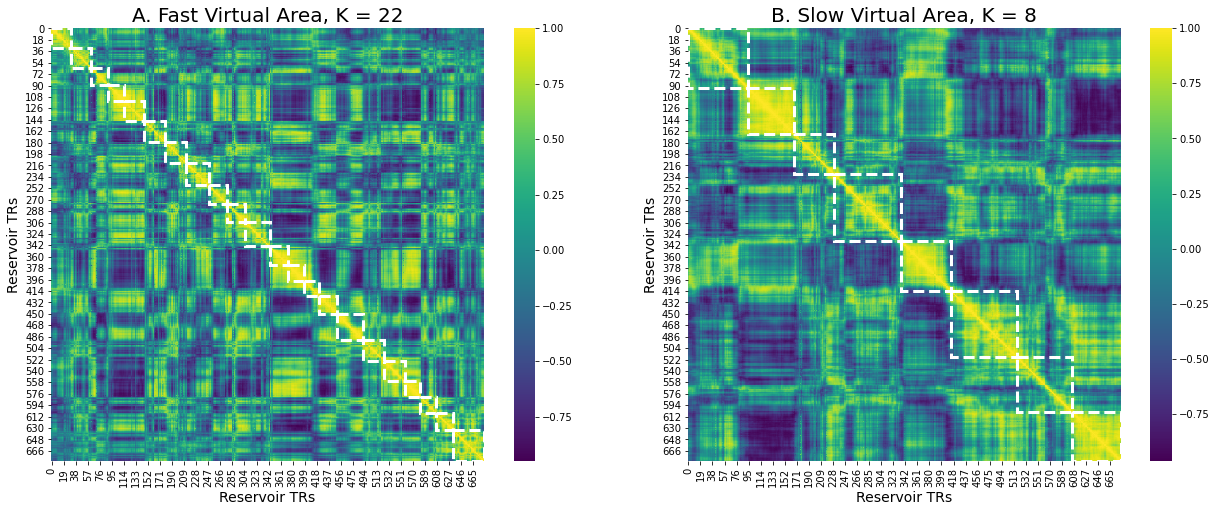

In [17]:
# 3 display the segmentation
color='viridis'
ec='white'
scale=0.9
lw=3

fs1 = 14
fs2 = 20

nTR=682
fig=plt.figure(figsize=(18, 7))

fig.add_subplot(121)
bounds = np.where(np.diff(np.argmax(ev_time1.segments_[0], axis=1)))[0]

#plt.imshow(np.corrcoef(NTF_time1),cmap=color, vmin=scale, vmax=1)
#plt.imshow(np.corrcoef(NTF_time1),cmap=color)
sns.heatmap(np.corrcoef(NTF_time1), cmap = 'viridis',square=True)

ax = plt.gca()
bounds_aug = np.concatenate(([0],bounds,[nTR]))
for i in range(len(bounds_aug)-1):
    rect = patches.Rectangle((bounds_aug[i],bounds_aug[i]),bounds_aug[i+1]-bounds_aug[i],bounds_aug[i+1]-bounds_aug[i],linewidth=lw, linestyle='--',edgecolor=ec,facecolor='none')
    ax.add_patch(rect)

plt.xlabel('Reservoir TRs', fontsize = fs1)
plt.ylabel('Reservoir TRs', fontsize = fs1)

plt.title('A. Fast Virtual Area, K = 22', fontsize = fs2)

fig.add_subplot(122)
bounds = np.where(np.diff(np.argmax(ev_time2.segments_[0], axis=1)))[0]

#plt.imshow(np.corrcoef(NTF_time2),cmap=color, vmin=scale, vmax=1)
#plt.imshow(np.corrcoef(NTF_time2),cmap=color)
sns.heatmap(np.corrcoef(NTF_time2), cmap = 'viridis',square=True)

ax = plt.gca()
bounds_aug = np.concatenate(([0],bounds,[nTR]))
for i in range(len(bounds_aug)-1):
    rect = patches.Rectangle((bounds_aug[i],bounds_aug[i]),bounds_aug[i+1]-bounds_aug[i],bounds_aug[i+1]-bounds_aug[i],linewidth=lw, linestyle='--',edgecolor=ec,facecolor='none')
    ax.add_patch(rect)

plt.xlabel('Reservoir TRs', fontsize = fs1)
plt.ylabel('Reservoir TRs', fontsize = fs1)

plt.title('B. Slow Virtual Area, K = 8', fontsize = fs2)


fig.tight_layout()
plt.savefig('Exp4-june10.png')

In [19]:
tmatrix=np.zeros([kvalues,kvalues])
pmatrix=np.zeros([kvalues,kvalues])
dmatrix=np.zeros([kvalues,kvalues])
                  

In [20]:
#likelihood = np.zeros([kvalues,reps,fastslow])
# compare all k pairs to see if the p values are significant

for j in range(kvalues):
    for i in range(j):
        # when i < j
        anti = (likelihood[i,:,0]+ likelihood[j,:,1])/2 # small k with fast area + large k with slow area 
        pro = (likelihood[j,:,0]+ likelihood[i,:,1])/2  # large k with fast area + small k with slow area
        dmatrix[i,j]=np.mean(pro-anti)
        t,p = stats.ttest_rel(pro,anti)
        tmatrix[i,j]=t
        pmatrix[i,j]=p
        #if t > 0 and p< 0.01:
        if p<0.01:
            print(i,j,t,p)


0 1 -3.489936846375941 0.0010319444049662614
0 2 -6.27261217699302 8.881569500364865e-08
1 2 -4.677788871184131 2.313044799535652e-05
0 3 -8.210789779936047 9.112851845074674e-11
1 3 -6.234907178208746 1.015735601910045e-07
2 3 -3.027052142763402 0.003929704250446025
0 4 -7.053436653390532 5.482846988667623e-09
1 4 -5.886870787370588 3.4944590782226266e-07
0 5 -6.768104054212201 1.5173177562073034e-08
1 5 -4.788965524442011 1.5888732637668002e-05
0 6 -7.067714511864915 5.210746090238659e-09
1 6 -5.501169517822163 1.3596638396229185e-06
0 7 -7.40232986037591 1.5832874248875202e-09
1 7 -5.6149017644751735 9.122026805568116e-07
0 8 -5.965888918708052 2.641346845532413e-07
1 8 -3.8581099296920374 0.0003340808315291874
3 8 3.2094649899072323 0.0023474838118088077
4 8 2.6943002463006644 0.009633521135322091
6 8 2.8828780180820597 0.005836767679972564
7 8 4.371447210945642 6.414139591855378e-05
0 9 -4.687411715115118 2.2393058641076316e-05
1 9 -2.699641498041434 0.009500278072262705
3 9 4.773

(20, 20)
49
0.00010983793516572682
0.0015159348524052768


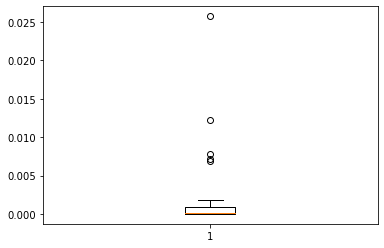

In [12]:
print(pmatrix.shape)

pmeans=np.zeros([50])
#likelihood = np.zeros([kvalues,reps,fastslow])
# compare all k pairs to see if the p values are significant

count=0
for i in range(3,8):
    for j in range(9,19):
        #print(i,j,pmatrix[i,j],count)
        pmeans[count]=pmatrix[i,j]
        count=count+1
print(count-1)
print(statistics.median(pmeans))
print(statistics.mean(pmeans))
plt.boxplot(pmeans)
plt.show()

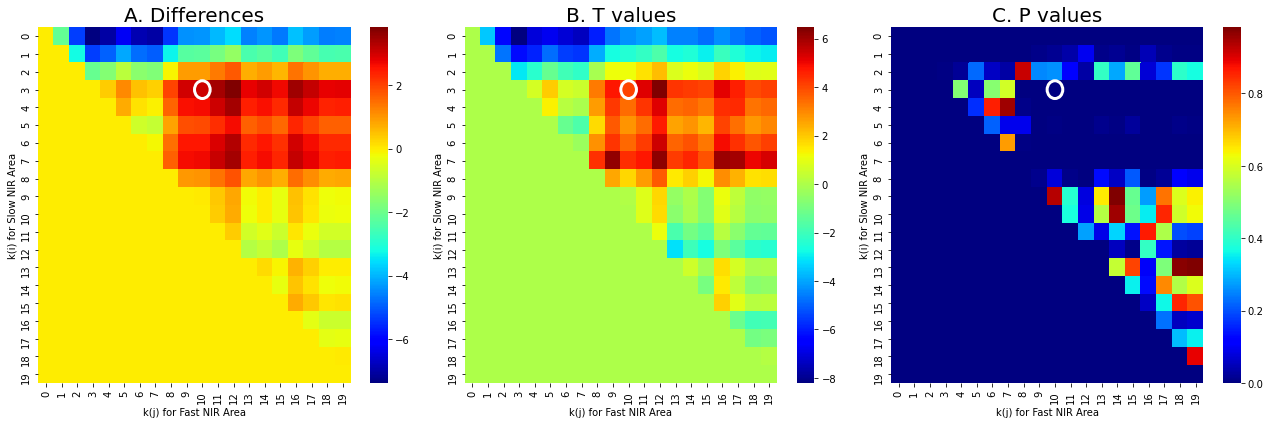

In [11]:
# 3 display the segmentation
color='jet'
ec='black'
scale=0.9
lw=2

fs1 = 14
fs2 = 20



fig=plt.figure(figsize=(18, 6))

fig.add_subplot(131)
ax = fig.gca()
circle2 = plt.Circle((10.5, 3.5), 0.5, color='w', fill=False,  lw=3)
ax.add_patch(circle2)
sns.heatmap(dmatrix, cmap=color)
plt.title('A. Differences', fontsize = fs2)
ax.set_xlabel('k(j) for Fast NIR Area')
ax.set_ylabel('k(i) for Slow NIR Area')

fig.add_subplot(132)
ax = fig.gca()
circle2 = plt.Circle((10.5, 3.5), 0.5, color='w', fill=False,  lw=3)
ax.add_patch(circle2)
sns.heatmap(tmatrix, cmap=color)
plt.title('B. T values', fontsize = fs2)
ax.set_xlabel('k(j) for Fast NIR Area')
ax.set_ylabel('k(i) for Slow NIR Area')

fig.add_subplot(133)
ax = fig.gca()
circle2 = plt.Circle((10.5, 3.5), 0.5, color='w', fill=False,  lw=3)
ax.add_patch(circle2)
sns.heatmap(pmatrix, cmap=color)
plt.title('C. P values', fontsize = fs2)
ax.set_xlabel('k(j) for Fast NIR Area')
ax.set_ylabel('k(i) for Slow NIR Area')

fig.tight_layout()
plt.savefig('likelihoodk-areas-no-norm.png')

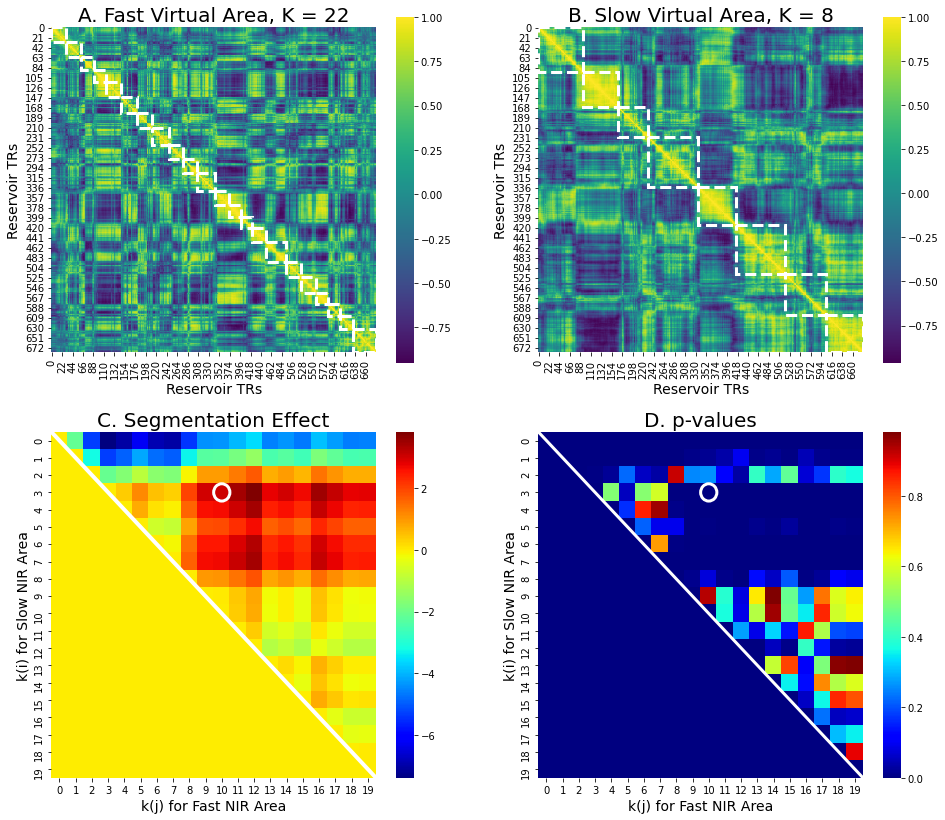

In [20]:
#new figure with the example and then the grid search
# display the segmentation
color='viridis'
ec='white'
scale=0.9
lw=3

fs1 = 14
fs2 = 20

nTR=682
fig=plt.figure(figsize=(16, 14))

fig.add_subplot(221)
bounds = np.where(np.diff(np.argmax(ev_time1.segments_[0], axis=1)))[0]

#plt.imshow(np.corrcoef(NTF_time1),cmap=color, vmin=scale, vmax=1)
#plt.imshow(np.corrcoef(NTF_time1),cmap=color)
sns.heatmap(np.corrcoef(NTF_time1), cmap = 'viridis',square=True)

ax = plt.gca()
bounds_aug = np.concatenate(([0],bounds,[nTR]))
for i in range(len(bounds_aug)-1):
    rect = patches.Rectangle((bounds_aug[i],bounds_aug[i]),bounds_aug[i+1]-bounds_aug[i],bounds_aug[i+1]-bounds_aug[i],linewidth=lw, linestyle='--',edgecolor=ec,facecolor='none')
    ax.add_patch(rect)

plt.xlabel('Reservoir TRs', fontsize = fs1)
plt.ylabel('Reservoir TRs', fontsize = fs1)

plt.title('A. Fast Virtual Area, K = 22', fontsize = fs2)

fig.add_subplot(222)
bounds = np.where(np.diff(np.argmax(ev_time2.segments_[0], axis=1)))[0]

#plt.imshow(np.corrcoef(NTF_time2),cmap=color, vmin=scale, vmax=1)
#plt.imshow(np.corrcoef(NTF_time2),cmap=color)
sns.heatmap(np.corrcoef(NTF_time2), cmap = 'viridis',square=True)

ax = plt.gca()
bounds_aug = np.concatenate(([0],bounds,[nTR]))
for i in range(len(bounds_aug)-1):
    rect = patches.Rectangle((bounds_aug[i],bounds_aug[i]),bounds_aug[i+1]-bounds_aug[i],bounds_aug[i+1]-bounds_aug[i],linewidth=lw, linestyle='--',edgecolor=ec,facecolor='none')
    ax.add_patch(rect)

plt.xlabel('Reservoir TRs', fontsize = fs1)
plt.ylabel('Reservoir TRs', fontsize = fs1)

plt.title('B. Slow Virtual Area, K = 8', fontsize = fs2)

##########################
color = 'jet'
fig.add_subplot(223)
ax = fig.gca()
circle2 = plt.Circle((10.5, 3.5), 0.5, color='w', fill=False,  lw=3)
ax.add_patch(circle2)
sns.heatmap(dmatrix, cmap=color)
plt.title('C. Segmentation Effect', fontsize = fs2)
ax.set_xlabel('k(j) for Fast NIR Area', fontsize = fs1)
ax.set_ylabel('k(i) for Slow NIR Area', fontsize = fs1)
ax.plot([1,0], [0,1], transform=ax.transAxes, color='w', lw=4)



fig.add_subplot(224)
ax = fig.gca()
circle2 = plt.Circle((10.5, 3.5), 0.5, color='w', fill=False,  lw=3)
ax.add_patch(circle2)
sns.heatmap(pmatrix, cmap=color)
plt.title('D. p-values', fontsize = fs2)
ax.set_xlabel('k(j) for Fast NIR Area', fontsize = fs1)
ax.set_ylabel('k(i) for Slow NIR Area', fontsize = fs1)
ax.plot([1,0], [0,1], transform=ax.transAxes, color='w',lw=3)




#fig.tight_layout()
plt.savefig('F10-Exp4-Combined.png', dpi=600)


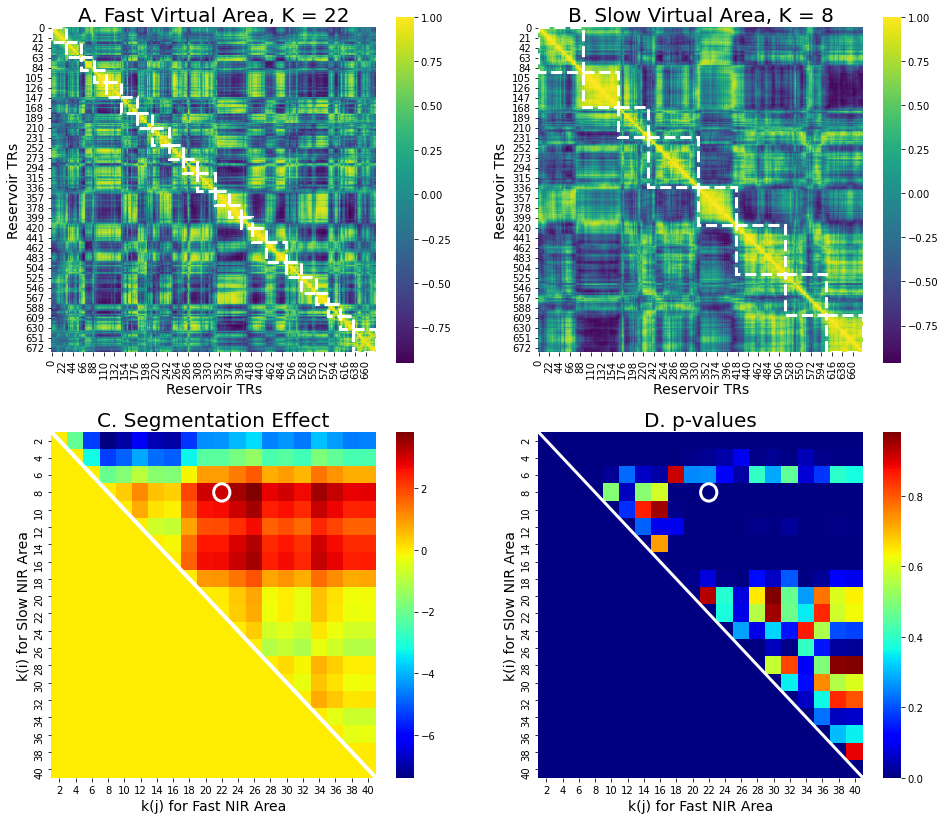

In [21]:
#new figure with the example and then the grid search
# display the segmentation
color='viridis'
ec='white'
scale=0.9
lw=3

fs1 = 14
fs2 = 20

nTR=682
fig=plt.figure(figsize=(16, 14))

fig.add_subplot(221)
bounds = np.where(np.diff(np.argmax(ev_time1.segments_[0], axis=1)))[0]

#plt.imshow(np.corrcoef(NTF_time1),cmap=color, vmin=scale, vmax=1)
#plt.imshow(np.corrcoef(NTF_time1),cmap=color)
sns.heatmap(np.corrcoef(NTF_time1), cmap = 'viridis',square=True)

ax = plt.gca()
bounds_aug = np.concatenate(([0],bounds,[nTR]))
for i in range(len(bounds_aug)-1):
    rect = patches.Rectangle((bounds_aug[i],bounds_aug[i]),bounds_aug[i+1]-bounds_aug[i],bounds_aug[i+1]-bounds_aug[i],linewidth=lw, linestyle='--',edgecolor=ec,facecolor='none')
    ax.add_patch(rect)

plt.xlabel('Reservoir TRs', fontsize = fs1)
plt.ylabel('Reservoir TRs', fontsize = fs1)

plt.title('A. Fast Virtual Area, K = 22', fontsize = fs2)

fig.add_subplot(222)
bounds = np.where(np.diff(np.argmax(ev_time2.segments_[0], axis=1)))[0]

#plt.imshow(np.corrcoef(NTF_time2),cmap=color, vmin=scale, vmax=1)
#plt.imshow(np.corrcoef(NTF_time2),cmap=color)
sns.heatmap(np.corrcoef(NTF_time2), cmap = 'viridis',square=True)

ax = plt.gca()
bounds_aug = np.concatenate(([0],bounds,[nTR]))
for i in range(len(bounds_aug)-1):
    rect = patches.Rectangle((bounds_aug[i],bounds_aug[i]),bounds_aug[i+1]-bounds_aug[i],bounds_aug[i+1]-bounds_aug[i],linewidth=lw, linestyle='--',edgecolor=ec,facecolor='none')
    ax.add_patch(rect)

plt.xlabel('Reservoir TRs', fontsize = fs1)
plt.ylabel('Reservoir TRs', fontsize = fs1)

plt.title('B. Slow Virtual Area, K = 8', fontsize = fs2)

##########################

A1 = np.linspace(2,40,20, dtype=int)
A2 = np.linspace(2,40,20, dtype=int)

color = 'jet'
fig.add_subplot(223)
ax = fig.gca()
circle2 = plt.Circle((10.5, 3.5), 0.5, color='w', fill=False,  lw=3)
ax.add_patch(circle2)
sns.heatmap(dmatrix, cmap=color, xticklabels=A1, yticklabels=A2)
plt.title('C. Segmentation Effect', fontsize = fs2)
ax.set_xlabel('k(j) for Fast NIR Area', fontsize = fs1)
ax.set_ylabel('k(i) for Slow NIR Area', fontsize = fs1)
ax.plot([1,0], [0,1], transform=ax.transAxes, color='w', lw=4)



fig.add_subplot(224)
ax = fig.gca()
circle2 = plt.Circle((10.5, 3.5), 0.5, color='w', fill=False,  lw=3)
ax.add_patch(circle2)
sns.heatmap(pmatrix, cmap=color, xticklabels=A1, yticklabels=A2)
plt.title('D. p-values', fontsize = fs2)
ax.set_xlabel('k(j) for Fast NIR Area', fontsize = fs1)
ax.set_ylabel('k(i) for Slow NIR Area', fontsize = fs1)
ax.plot([1,0], [0,1], transform=ax.transAxes, color='w',lw=3)




#fig.tight_layout()
plt.savefig('F10-Exp4-Combined.png', dpi=600)


Text(0, 0.5, 'Log likelihood difference')

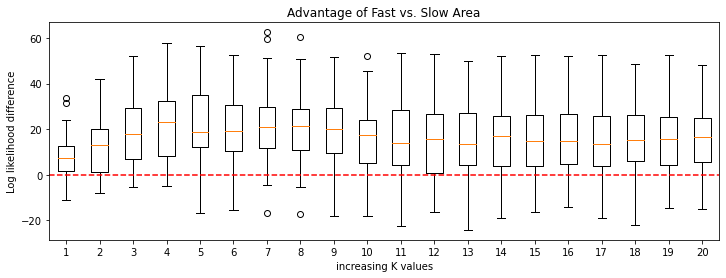

In [57]:
#likelihood = np.zeros([kvalues,reps,fastslow])
# small K is slow, likelihood 1 is slow
# high K is fast, likelihood 0 is fast

#model k
#slow slow - fast slow
#slow fast - fast fast


f, ax = plt.subplots(1,1, figsize=(12, 4))

ax.boxplot(likelihood[:,:,1].T-likelihood[:,:,0].T)
#ax.boxplot(likelihood[:,:,0].T)
#ax.boxplot(likelihood[:,:,1].T)
#ax.boxplot(likelihood)
#ax.plot(likelihood[:,1])

plt.axhline(y=0, color='r', linestyle='--')


ax.set_title('Advantage of Fast vs. Slow Area')
ax.set_xlabel('increasing K values')
ax.set_ylabel('Log likelihood difference')
#
#sns.despine()

(array([ 1.,  3.,  7.,  1., 11.,  8., 10.,  4.,  2.,  3.]),
 array([-754.27964058, -750.95169069, -747.62374079, -744.2957909 ,
        -740.967841  , -737.63989111, -734.31194121, -730.98399132,
        -727.65604142, -724.32809153, -721.00014163]),
 <BarContainer object of 10 artists>)

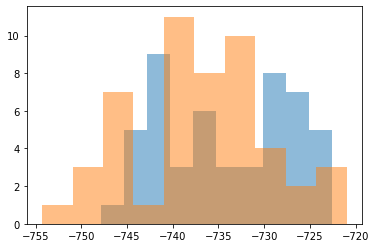

In [58]:
data3 = (likelihood[3,:,0]+ likelihood[10,:,1])/2
data4 = (likelihood[10,:,0]+ likelihood[3,:,1])/2

plt.hist(data4, alpha=0.5)
plt.hist(data3,alpha=0.5)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fdccca91a90>,
 'caps': [<matplotlib.lines.Line2D at 0x7fdccc94f110>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fdccc9454d0>,
 'medians': [<matplotlib.lines.Line2D at 0x7fdccc94f9d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fdccc94fe10>,
 'means': []}

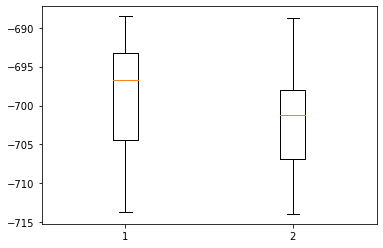

In [18]:
plt.boxplot([data4,data3])

In [59]:
#4 15 4.307048321216739 7.923701639107483e-05
t,p = stats.ttest_rel(data4,data3)
print(t)
print(p)
print(np.mean(data4-data3))

4.104585872767871
0.00015280988842107792
3.0518272712843624


In [20]:
print(np.shape(likelihood))
print(kvalues)

(20, 50, 2)
20


<AxesSubplot:>

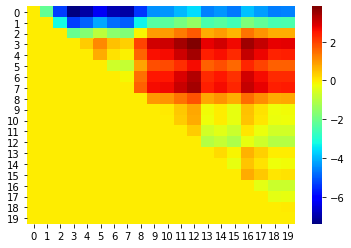

In [21]:
sns.heatmap(dmatrix,cmap='jet')

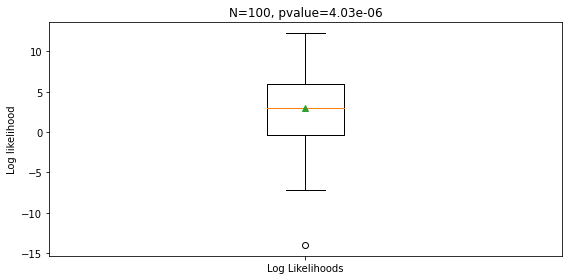

In [22]:

fig=plt.figure(figsize=(8, 4))
#f,ax = plt.subplots(1,1, figsize=(5, 5))
plt.boxplot(data4-data3,showmeans=True)
#plt.xlabel('Coherent                                    Incoherent')
plt.ylabel('Log likelihood')
#plt.axhline(y=0, color='r', linestyle='--')

plt.xticks([1], ['Log Likelihoods'])#ax.set_xticklabels(['Coherent-Incoherent'])
plt.title('N=100, pvalue=4.03e-06')
fig.tight_layout()
plt.savefig('temp2.png')

IndexError: index 25 is out of bounds for axis 0 with size 20

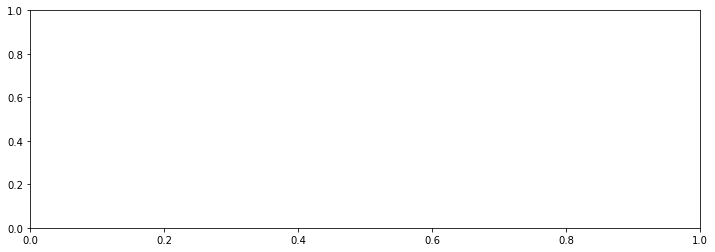

In [23]:
f, ax = plt.subplots(1,1, figsize=(12, 4))

ax.plot(likelihood[4,:,0]-likelihood[25,:,1])
#ax.boxplot(likelihood)
#ax.plot(likelihood[:,1])

plt.axhline(y=0, color='r', linestyle='--')


ax.set_title('Advantage of Fast vs. Slow Area')
ax.set_xlabel('increasing K values')
ax.set_ylabel('Log likelihood difference')
#
#sns.despine()

In [6]:
likelihood = np.load('likelihood-june10.npy')

In [17]:
#np.save('NTF-time1-june6.npy', NTF_time1) 
#np.save('NTF-time2-june6.npy', NTF_time2) 

#np.save('likelihood-june6.npy', likelihood) 

NTF_time1 = np.load('NTF-time1-last-june10.npy')
NTF_time2 = np.load('NTF-time2-last-june10.npy')

In [7]:
NTF_time1 = np.load('NTF-time1-june10.npy')
NTF_time2 = np.load('NTF-time2-june10.npy')